In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

In [3]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [11]:
file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample

['BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_seg.nii.gz']

In [12]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
#VOLUME_SLICES = 100  
VOLUME_SLICES = 5 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [19]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [26]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_t2.nii.gz']

In [27]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

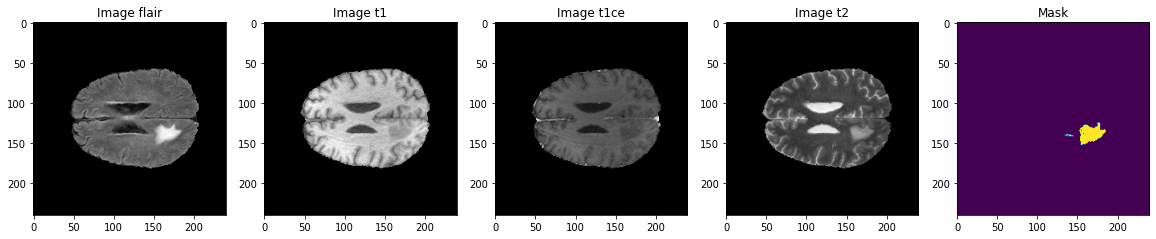

In [28]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

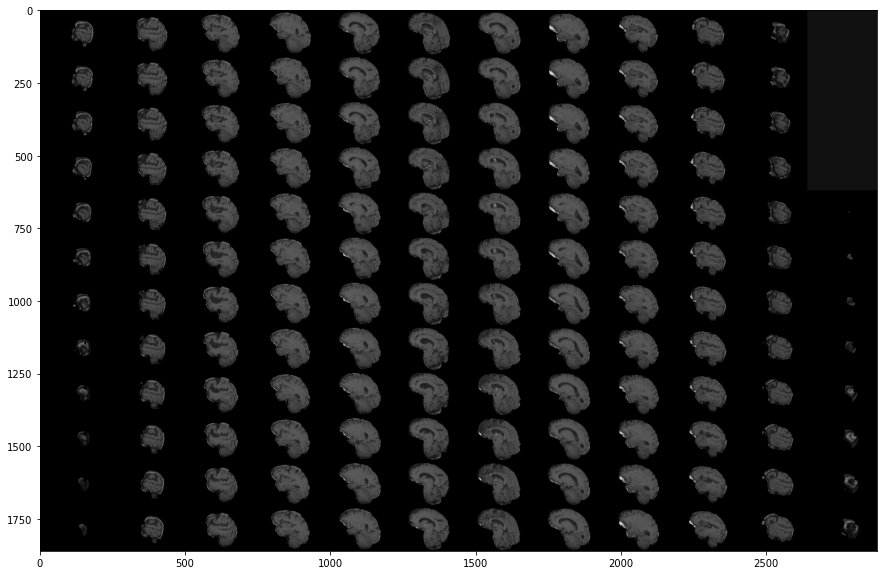

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

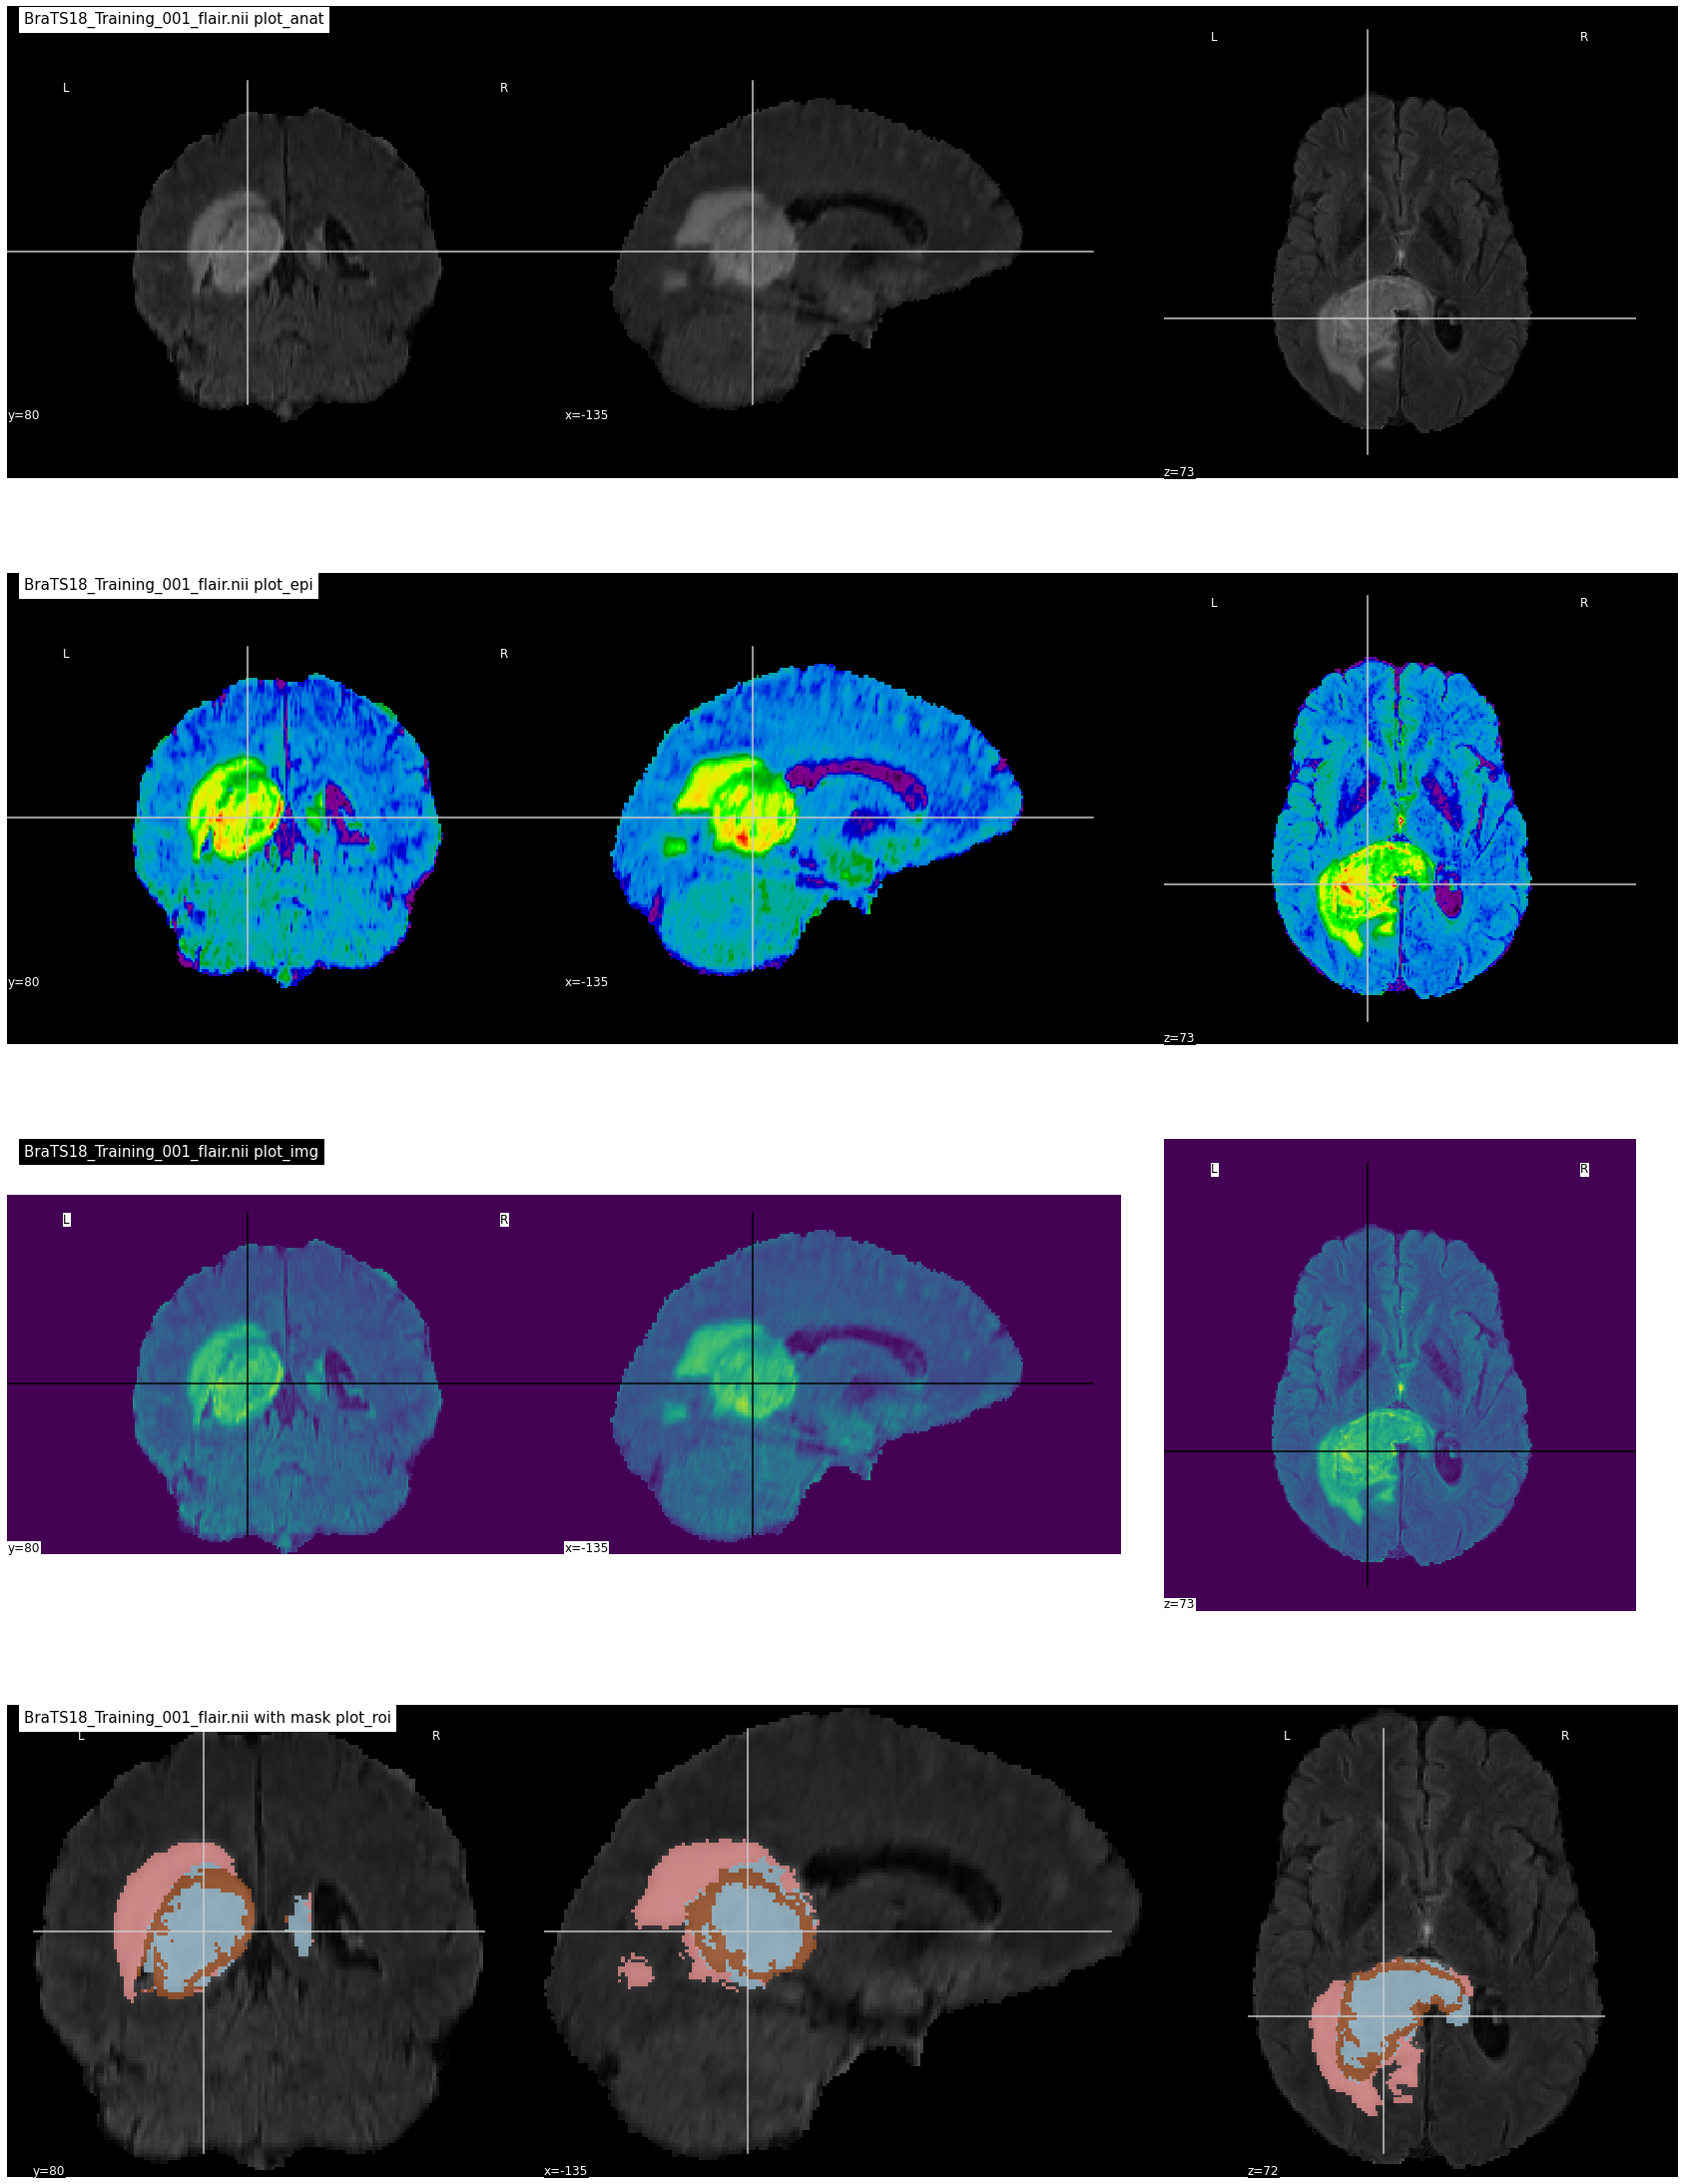

In [29]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS18_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS18_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS18_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS18_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [24]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [30]:
def build_unet(inputs, ker_init):
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)
     
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
model = build_unet(input_layer, 'he_normal')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

2022-08-20 06:59:54.253275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 06:59:54.380291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 06:59:54.381454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 06:59:54.384046: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [31]:
model.input_shape

(None, 128, 128, 128, 3)

In [32]:
model.output_shape

(None, 128, 128, 128, 4)

In [39]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [40]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        #y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim))
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii.gz'); 
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            #seg=seg.astype(np.uint8)
            #seg[seg==4] = 3

            #temp_combined_images = np.stack([flair, ce, t2], axis=3)
            #temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
            #temp_mask = seg[56:184, 56:184, 13:141]
            
            slice_w = 25

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,:,0] = cv2.resize(flair[:,:,flair.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,:,1] = cv2.resize(ce[:,:,ce.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,:,2] = cv2.resize(t2[:,:,t2.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));

                #y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                Y[j +VOLUME_SLICES*c,:,:,:] = cv2.resize(seg[:,:,seg.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));
                    
        # Generate masks
        #y[y==4] = 3;
        Y[Y==4] = 3;
        mask = tf.one_hot(Y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), mask
        #return temp_combined_images/np.max(temp_combined_images), temp_mask
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [36]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

850
251
150


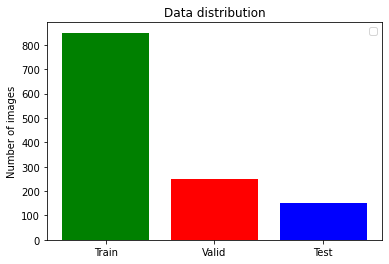

In [37]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()
    
showDataLayout()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2018_3D_UNet.log')

history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )  

2022-08-20 07:03:29.984468: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83886080 exceeds 10% of free system memory.
2022-08-20 07:03:30.496730: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 125829120 exceeds 10% of free system memory.
2022-08-20 07:03:30.710356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-20 07:03:34.023957: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83886080 exceeds 10% of free system memory.
2022-08-20 07:03:34.425005: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167772160 exceeds 10% of free system memory.
2022-08-20 07:03:34.556252: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 125829120 exceeds 10% of free system memory.
2022-08-20 07:03:36.326624: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


850/850 [==============================] - 2362s 3s/step - loss: 0.1370 - accuracy: 0.9757 - mean_io_u: 0.6112 - dice_coef: 0.2658 - precision: 0.9749 - sensitivity: 0.9603 - specificity: 0.9925 - dice_coef_necrotic: 0.0166 - dice_coef_edema: 0.0926 - dice_coef_enhancing: 0.0131 - val_loss: 0.0898 - val_accuracy: 0.9735 - val_mean_io_u: 0.5119 - val_dice_coef: 0.2860 - val_precision: 0.9743 - val_sensitivity: 0.9728 - val_specificity: 0.9915 - val_dice_coef_necrotic: 0.0225 - val_dice_coef_edema: 0.1504 - val_dice_coef_enhancing: 0.0197

Epoch 00001: val_accuracy improved from -inf to 0.97351, saving model to 3D-UNet-2018-weights-improvement-01-0.974.hdf5
Epoch 2/30
850/850 [==============================] - 2349s 3s/step - loss: 0.0884 - accuracy: 0.9774 - mean_io_u: 0.4979 - dice_coef: 0.2786 - precision: 0.9787 - sensitivity: 0.9751 - specificity: 0.9929 - dice_coef_necrotic: 0.0193 - dice_coef_edema: 0.1218 - dice_coef_enhancing: 0.0196 - val_loss: 0.0895 - val_accuracy: 0.9735 - v

In [5]:
pwd

'/kaggle/working'

In [7]:
ln = len(os.listdir('/kaggle/working'))
ln

3